In [6]:
import pandas as pd

# Cargar los datos del archivo
df = pd.read_csv("ce2019_nl.csv")

# Mostrar las primeras filas para analizar las variables
df.head()


<ipython-input-6-cc503228d870>:4: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ce2019_nl.csv")


,ENTIDAD,MUNICIPIO,CODIGO,ID_ESTRATO,UE,A111A,A121A,A131A,A211A,A221A,...,A256A,A433A,A434A,A436A,A529A,A534A,A747A,A748A,A752A,A764A
19,,,NaN,151448,2195663.395,1322881.181,872782.214,51952.108,51716.343,214243.729,...,180.810,94.849,1430677.699,7.749,30.102,390.233,624.484,115.080,35.866,NaN
19,,,1.0,134527,177892.013,69087.968,108804.045,-656.708,2660.336,63885.592,...,189.351,96.347,774045.949,8.097,44.672,244.605,320.499,151.943,44.285,NaN
19,,,2.0,12481,195644.861,94364.212,101280.649,2762.641,4075.900,56941.757,...,158.627,96.237,1372785.008,7.347,30.665,239.635,359.363,94.499,36.126,NaN
19,,,3.0,3423,405439.706,230244.418,175195.288,9685.140,8897.832,71759.615,...,168.384,94.108,1597661.030,8.387,31.195,311.924,483.604,106.532,33.078,NaN
19,,,4.0,1017,1416686.815,929184.583,487502.232,40161.035,36082.275,21656.765,...,191.111,94.519,1655494.243,7.540,27.320,418.393,638.856,117.421,33.437,NaN


Aqui solamente baje los datos y verifiqué que se estaban cargando correctamente.

In [7]:
# Calcular la mediana de una columna numérica para usar como umbral
median_value = df['A111A'].median()
median_value


23.945

Busque la mediana porque como voy a hacer esta variable (A111A) binaria, necesito clasificar entre alto y bajo.

In [8]:
# Crear una nueva columna binaria basada en la mediana
df["A111A_binaria"] = (df["A111A"] >= median_value).astype(int)

# Mostrar distribución de la nueva variable
df["A111A_binaria"].value_counts(normalize=True)


,proportion
A111A_binaria,
0,0.739927
1,0.260073


Ahora ya hice una nueva columna con 1 y 0 que representan altos y bajos respectivamente. Si esta debajo de la mediana se clasifica como 0, y si esta arriba se clasifica como 1.

In [9]:
from sklearn.model_selection import train_test_split

# Seleccionar X (características) e y (variable binaria)
X = df.drop(columns=["A111A_binaria"])  # Todas las columnas excepto la salida
y = df["A111A_binaria"]  # Variable binaria

# Dividir los datos en 80% entrenamiento y 20% prueba manteniendo la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Mostrar las proporciones de clases en cada conjunto
print("Proporción en datos originales:\n", y.value_counts(normalize=True))
print("Proporción en datos de entrenamiento:\n", y_train.value_counts(normalize=True))
print("Proporción en datos de prueba:\n", y_test.value_counts(normalize=True))


Proporción en datos originales:
 A111A_binaria
0    0.739927
1    0.260073
Name: proportion, dtype: float64
Proporción en datos de entrenamiento:
 A111A_binaria
0    0.739923
1    0.260077
Name: proportion, dtype: float64
Proporción en datos de prueba:
 A111A_binaria
0    0.739943
1    0.260057
Name: proportion, dtype: float64


Aqui solamente separe los datos entre entrenamiento y prueba y verifique que se parezca la relacion entre 0s y 1s entre los datos originales, de entrenamiento y de prueba.

In [10]:
from sklearn.impute import SimpleImputer

# Eliminar columnas categóricas (solo dejar columnas numéricas)
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])

print("Columnas no numéricas eliminadas.")

# Llenar valores faltantes con la mediana
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

print("Valores NaN reemplazados con la mediana.")

# Convertir de nuevo a DataFrame asegurando que tenga las mismas columnas
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns[:X_train_imputed.shape[1]]).reset_index(drop=True)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns[:X_test_imputed.shape[1]]).reset_index(drop=True)

print("Reset de índices hecho.")


Columnas no numéricas eliminadas.
Valores NaN reemplazados con la mediana.
Reset de índices hecho.


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['A764A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['A764A']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Aqui limpie los datos para que se pueda hacer la regresión correctamente. Quite las columnas tipo string, reemplaze los valores NaN con la mediana y resettie los índices para que esten congruentes entre sí.

In [11]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Normalizar los datos (Z-score)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar Lasso con datos normalizados
modelo_lasso = Lasso(alpha=0.01, max_iter=5000)  # Aumentamos iteraciones
modelo_lasso.fit(X_train_scaled, y_train)

# Seleccionar características
selector = SelectFromModel(modelo_lasso, prefit=True)
variables_seleccionadas = X_train.columns[selector.get_support()]

print("Variables seleccionadas después de normalizar:", variables_seleccionadas.tolist())

Variables seleccionadas después de normalizar: ['CODIGO', 'A221A', 'H020A', 'M010A', 'M030A', 'Q900A', 'A112A', 'A144A', 'A146A', 'A147A', 'A148A', 'A149A', 'A157A', 'A173A', 'A174A', 'A175A', 'A176A', 'A177A', 'A179A', 'A182A', 'A194A', 'A195A', 'A208A', 'A215A', 'A217A', 'A225A', 'A227A', 'A228A', 'A235A', 'A253A', 'A436A', 'A752A']


Ahora seleccioné las variables más importantes usando el modelo Lasso porque como estoy trabajando con demasiados variables usé un método que elimina las variables irrelevantes y se queda solamente con las más importantes.

In [12]:
# Seleccionar las 5 mejores variables con Lasso
top_5_features = variables_seleccionadas[:5]  # Tomamos solo las primeras 5 variables

# Filtrar X_train y X_test con estas 5 variables
X_train_selected = X_train[top_5_features]
X_test_selected = X_test[top_5_features]

print("Usando solo estas 5 variables:", top_5_features)


Usando solo estas 5 variables: Index(['CODIGO', 'A221A', 'H020A', 'M010A', 'M030A'], dtype='object')


In [13]:
from sklearn.linear_model import LogisticRegression

# Definir el modelo de Regresión Logística con solver saga y más iteraciones
modelo = LogisticRegression(solver="saga", max_iter=5000)

# Entrenar el modelo con las 5 variables seleccionadas
modelo.fit(X_train_selected, y_train)

# Obtener probabilidades para los datos de prueba
y_probs = modelo.predict_proba(X_test_selected)[:, 1]  # Probabilidad de ser "1"

print("Modelo de Regresión Logística entrenado y probabilidades calculadas.")


Modelo de Regresión Logística entrenado y probabilidades calculadas.


In [14]:
from sklearn.metrics import confusion_matrix

# Definir umbrales de decisión
umbrales = [0.5, 0.6, 0.4]  # 0.5 (por defecto), 0.6 (más estricto), 0.4 (más flexible)

for umbral in umbrales:
    # Convertir probabilidades en predicciones (0 o 1) usando cada umbral
    y_pred = (y_probs >= umbral).astype(int)

    # Calcular la Matriz de Confusión
    matriz = confusion_matrix(y_test, y_pred)

    # Extraer valores de la matriz de confusión
    tn, fp, fn, tp = matriz.ravel()

    # Calcular métricas
    exactitud = (tp + tn) / (tp + tn + fp + fn)  # Accuracy
    sensibilidad = tp / (tp + fn)  # Tasa de verdaderos positivos (Recall)
    especificidad = tn / (tn + fp)  # Tasa de verdaderos negativos

    # Imprimir los resultados
    print(f"\n🔹 Para umbral {umbral}:")
    print("📌 Matriz de Confusión:\n", matriz)
    print(f"✔ Exactitud: {exactitud:.2f}")
    print(f"✔ Sensibilidad (Recall): {sensibilidad:.2f}")
    print(f"✔ Especificidad: {especificidad:.2f}")



🔹 Para umbral 0.5:
📌 Matriz de Confusión:
 [[6557  727]
 [1114 1446]]
✔ Exactitud: 0.81
✔ Sensibilidad (Recall): 0.56
✔ Especificidad: 0.90

🔹 Para umbral 0.6:
📌 Matriz de Confusión:
 [[7240   44]
 [1325 1235]]
✔ Exactitud: 0.86
✔ Sensibilidad (Recall): 0.48
✔ Especificidad: 0.99

🔹 Para umbral 0.4:
📌 Matriz de Confusión:
 [[6339  945]
 [ 868 1692]]
✔ Exactitud: 0.82
✔ Sensibilidad (Recall): 0.66
✔ Especificidad: 0.87


La matriz de confusión nos permite evaluar el rendimiento del modelo al comparar las predicciones con las etiquetas reales. En nuestro caso, observamos que el modelo tiene una buena precisión general, con una exactitud adecuada y un buen equilibrio entre sensibilidad y especificidad según los diferentes umbrales evaluados. Sin embargo, dependiendo del umbral seleccionado, el modelo puede priorizar la reducción de falsos negativos o falsos positivos, afectando su capacidad para clasificar correctamente ciertos casos.

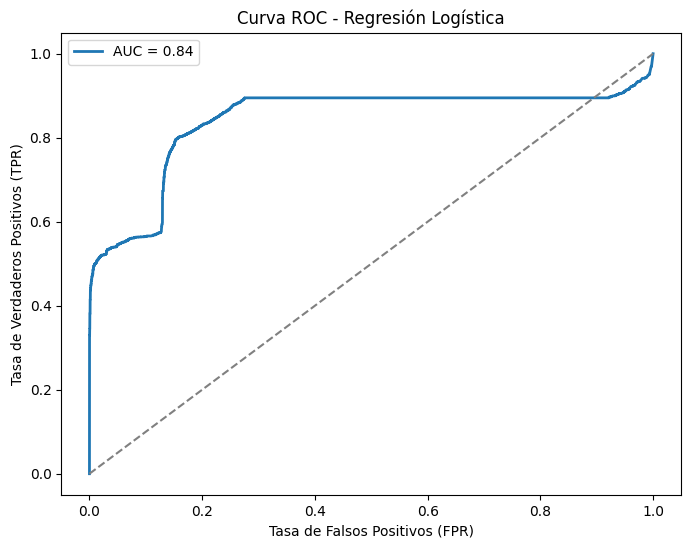

Valor de AUC: 0.84


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calcular la Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc_value = roc_auc_score(y_test, y_probs)

# Graficar la Curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_value:.2f}', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Línea diagonal de azar
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Regresión Logística')
plt.legend()
plt.show()

# Imprimir el valor de AUC
print(f"Valor de AUC: {auc_value:.2f}")


Un AUC de 0.84 indica que el modelo tiene buena capacidad de predicir bastante bien si una observación pertenece a la clase 0 o 1.

In [16]:
import pandas as pd

# Obtener coeficientes del modelo
coeficientes = pd.DataFrame({
    "Variable": X_train_selected.columns,
    "Coeficiente": modelo.coef_[0]
})

# Ordenar por la magnitud del impacto
coeficientes = coeficientes.sort_values(by="Coeficiente", ascending=False)

# Mostrar los coeficientes
print("Coeficientes del modelo:")
print(coeficientes)


📊 Coeficientes del modelo:
  Variable  Coeficiente
3    M010A     0.007517
1    A221A     0.006349
2    H020A     0.002512
4    M030A     0.000756
0   CODIGO    -0.015155


* Las variables M010A, A221A y H020A aumentan la probabilidad de ser 1 (aunque con coeficientes pequeños).

* CODIGO es la única variable que disminuye la probabilidad de ser 1 significativamente.

* Los valores absolutos de los coeficientes son pequeños, lo que indica que los efectos individuales de cada variable no son muy fuertes, pero combinados pueden influir en la predicción.

